In [2]:
import numpy as np 
import pandas as pd 
import csv
import os
import re
import spacy


for dirname, _, filenames in os.walk('/CSC172/K Means Project/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
data = pd.read_csv('SPAM_SMS.csv')

In [5]:

# Focus only on the 'text' column, drop the other columns
data = data[['text']]

# Data Cleaning
# Normalize Text: Convert all text to lowercase
data['text'] = data['text'].str.lower()

# Remove Punctuation
data['text'] = data['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# Strip Extra Spaces
data['text'] = data['text'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

# Save the cleaned data to a new file
data.to_csv('initial_cleaned.csv', index=False)

print("Data cleaning completed and saved as 'initial_cleaned.csv'")


Data cleaning completed and saved as 'initial_cleaned.csv'


In [6]:


# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

# Load your dataset
data = pd.read_csv('initial_cleaned.csv')

# Load and clean stopword files
with open('english-stopwords.txt', 'r') as file:
    english_stopwords = set(word.strip().lower() for word in file.readlines())

with open('genediazjr-tagalog.txt', 'r') as file:
    filipino_stopwords = set(word.strip().lower() for word in file.readlines())

# Combine English and Filipino stopwords
stopwords_combined = english_stopwords.union(filipino_stopwords)

# Preprocess text
def preprocess_text(text):
    # Tokenize and remove stopwords
    doc = nlp(text)
    tokens = [token.text.lower() for token in doc if token.text.lower() not in stopwords_combined and token.is_alpha]
    return " ".join(tokens)  # Join tokens back into a string if needed

# Apply preprocessing
data['stopwords_removed'] = data['text'].apply(preprocess_text)

# Save the processed data
data.to_csv('stopwords_removed.csv', index=False)
print("Processed data saved as 'stopwords_removed.csv'")


Processed data saved as 'stopwords_removed.csv'


In [7]:
# Load English word list from nltk or a local file
import nltk
nltk.download('words')
from nltk.corpus import words
english_words = set(words.words())

# Load Tagalog word list
with open('Filipino-wordlist.txt', 'r', encoding='utf-8') as file:
    tagalog_words = set(word.strip().lower() for word in file.readlines())

# Combine English and Tagalog word lists
valid_words = english_words.union(tagalog_words)

[nltk_data] Downloading package words to D:\Documents\4th year
[nltk_data]     files\CSC172\K Means Project\.venv\Lib\site-
[nltk_data]     packages\nltk...
[nltk_data]   Package words is already up-to-date!


In [8]:
def preprocess_text(text):
    # Tokenize and filter out invalid words
    doc = nlp(text)
    tokens = [
        token.text.lower() 
        for token in doc 
        if token.is_alpha and token.text.lower() in valid_words
    ]
    
    # Remove duplicated words while keeping the first occurrence
    unique_tokens = []
    seen = set()
    for token in tokens:
        if token not in seen:
            unique_tokens.append(token)
            seen.add(token)
    
    return " ".join(unique_tokens)

# Apply preprocessing
data['cleaned_text'] = data['stopwords_removed'].apply(preprocess_text)

# Save the cleaned data
data.to_csv('processed_filtered_data.csv', index=False)
print("Processed data with valid words and no duplicates saved as 'processed_filtered_data.csv'")

Processed data with valid words and no duplicates saved as 'processed_filtered_data.csv'


In [15]:
def detect_language(text):
    # Tokenize the text
    words = text.split()
    
    if not words:  # Handle empty strings
        return 'unknown'
    
    # Count words in each language
    eng_count = sum(1 for word in words if word in english_words)
    tag_count = sum(1 for word in words if word in tagalog_words)
    total_count = len(words)
    
    # Calculate percentages
    eng_percentage = eng_count / total_count
    tag_percentage = tag_count / total_count
    
    # Determine language based on percentage thresholds
    if eng_percentage > 0.5:  # 60% or more English words
        return 'english'
    elif tag_percentage > 0.4:  # 60% or more Tagalog words
        return 'tagalog'
    else:
        return 'unknown'

# Apply language detection
data['language'] = data['cleaned_text'].apply(detect_language)

# Split datasets based on detected language
tagalog_data = data[data['language'] == 'tagalog']
english_data = data[data['language'] == 'english']
unknown_data = data[data['language'] == 'unknown']

# Save the datasets
tagalog_data.to_csv('tagalog_texts.csv', index=False)
english_data.to_csv('english_texts.csv', index=False)
unknown_data.to_csv('unknown_texts.csv', index=False)

print("Data split into 'tagalog_texts.csv', 'english_texts.csv', and 'unknown_texts.csv'")


Data split into 'tagalog_texts.csv', 'english_texts.csv', and 'unknown_texts.csv'


In [16]:
import pandas as pd

# Load your dataset
data = pd.read_csv('tagalog_texts.csv')

# Drop rows containing 'content not supported' in the 'text' column
data = data[~data['text'].str.contains('content not supported', case=False, na=False)]

# Save the updated dataset
data.to_csv('tagalog_texts.csv', index=False)

print("Rows containing 'content not supported' have been removed. Updated data saved as 'tagalog_texts.csv'.")


Rows containing 'content not supported' have been removed. Updated data saved as 'tagalog_texts.csv'.


------------------------------

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
import plotly.express as px
import pandas as pd


tagalog_path = "tagalog_texts.csv"  
tpf = pd.read_csv(tagalog_path)

english_path = "english_texts.csv"  
epf = pd.read_csv(english_path)

In [78]:
# Step 1: Vectorize text using TF-IDF
vectorizer = CountVectorizer()   # Adjust features as needed
TX =  vectorizer.fit_transform(tpf['cleaned_text'])

vectorizer = CountVectorizer()   # Adjust features as needed
EX =  vectorizer.fit_transform(epf['cleaned_text'])

TX_dense = TX.toarray()
EX_dense = EX.toarray()

In [79]:
tag_data_points = TX.shape[0]
print(f"Tagalog data points: {tag_data_points}")

eng_data_points = EX.shape[0]
print(f"English data points: {eng_data_points}")

Tagalog data points: 300
English data points: 634


In [105]:
tag_documents = pd.read_csv('tagalog_texts.csv')
tdocuments = tag_documents['cleaned_text'].tolist()

eng_documents = pd.read_csv('english_texts.csv')
edocuments = eng_documents['cleaned_text'].tolist()

In [71]:
print(type(tag_documents))


<class 'pandas.core.frame.DataFrame'>


Silhouette Score: 0.25929694737763714


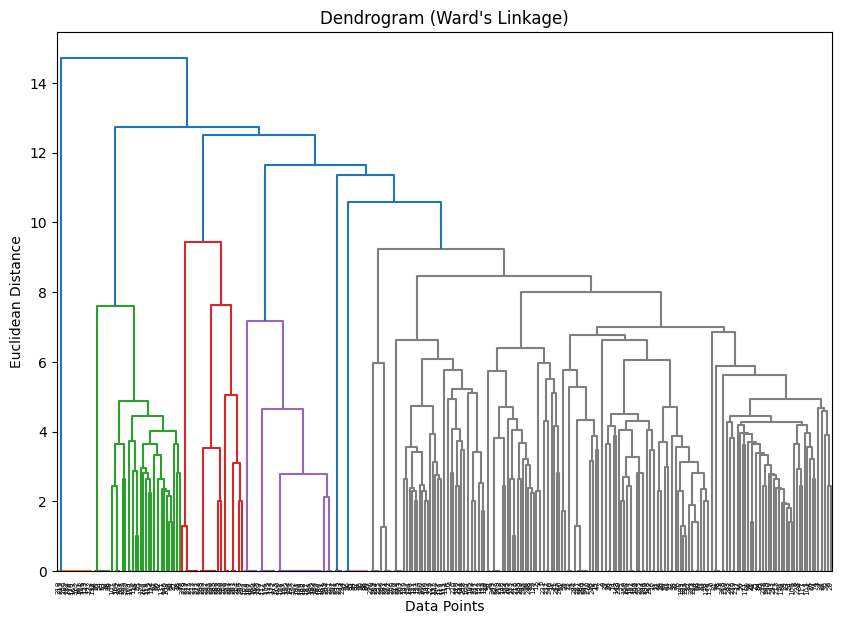

AttributeError: 'list' object has no attribute 'iloc'

In [104]:
# Step 1: Reduce data to 3D using PCA
pca = PCA(n_components=20)
TX_reduced = pca.fit_transform(TX_dense)

# Step 2: Agglomerative Hierarchical Clustering
# Using Ward's linkage method
k = 7  # Specify the number of clusters
# Use PCA-reduced data for clustering instead of original data
agg_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
labels = agg_clustering.fit_predict(TX_reduced)  # Use TX_reduced for clustering

# Step 3: Evaluate clustering with silhouette score
silhouette_avg = silhouette_score(TX_reduced, labels)
print(f"Silhouette Score: {silhouette_avg}")

# Step 4: Visualization of dendrogram
plt.figure(figsize=(10, 7))
plt.title("Dendrogram (Ward's Linkage)")
dendrogram = sch.dendrogram(sch.linkage(TX_dense, method='ward'))
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

documents = tdocuments.iloc[:, 2]

# Trim the documents array to match the length of TX_reduced and labels
documents = tag_documents[:len(TX_reduced)]  # Cleaned text
original_texts = tpf['text']  # Original text
documents = documents[:len(TX_reduced)]
original_texts = original_texts[:len(TX_reduced)]

# Select the first 3 principal components for visualization
TX_reduced = TX_reduced[:, :3]

# Now create the DataFrame with the matched lengths
data_visualization = pd.DataFrame({
    'PCA1': TX_reduced[:, 0],
    'PCA2': TX_reduced[:, 1],
    'PCA3': TX_reduced[:, 2],
    'Cluster': labels,
    'Document': documents,
    'Original': original_texts  # Uncomment if you want to include original text
})

# Check that the lengths of the columns match
print(f"Length of TX_reduced: {len(TX_reduced)}")
print(f"Length of documents: {len(documents)}")
print(f"Length of original_texts: {len(original_texts)}")
print(f"Length of labels: {len(labels)}")

# Create a 3D scatter plot using Plotly
fig = px.scatter_3d(
    data_visualization,
    x='PCA1',
    y='PCA2',
    z='PCA3',
    color='Cluster',
    hover_data={
        'Document': True,          # Cleaned text
        'Original': True,          # Original text
        'Cluster': True,           # Cluster ID
    },
    title="Agglomerative Clustering (Interactive 3D Visualization)"
)

# Customize the layout
fig.update_layout(
    scene=dict(
        xaxis_title='PCA Component 1',
        yaxis_title='PCA Component 2',
        zaxis_title='PCA Component 3',
    ),
    coloraxis_colorbar=dict(title="Cluster"),
    margin=dict(l=0, r=0, b=0, t=40)  # Adjust margins
)

# Show the plot
fig.show()


In [97]:
# Display each cluster as a separate table with left-aligned text
grouped = data_visualization.groupby('Cluster')
for cluster, group in grouped:
    print(f"Cluster {cluster}:")
    display(group[['Original', 'Document']].style.set_properties(subset=['Original', 'Document'], **{'text-align': 'left'}))
    print("\n")


Cluster 0:


,Original,Document
256,kumuha ng libreng p167 maglagay lamang ng p102 upang makuha claimcenteruk,libreng maglagay upang makuha
257,na refund na sa iyong account ang p2160 mag register at maglagay ng p100 upang makuha vvgouk,refund account register maglagay upang makuha
259,phprizeuk claim here nanalo ka ng p2760 kunin na ang inyong premyo ngayon bisitahin ang link na ito upang makuha ang inyong napanalunan,claim nanalo kunin premyo bisitahin link upang makuha napanalunan
261,phcasinouk claim here nanalo ka ng p2760 kunin na ang inyong premyo ngayon bisitahin ang link na ito upang makuha ang inyong napanalunan,claim nanalo kunin premyo bisitahin link upang makuha napanalunan
263,phvegasuk claim here nanalo ka ng p2760 maglagay lamang ng p100 upang makuha ang panalo,claim nanalo maglagay upang makuha panalo
264,phvegasuk claim here nanalo ka ng p2760 maglagay lamang ng p100 upang makuha ang panalo,claim nanalo maglagay upang makuha panalo
267,winner4bonusuk claim here nanalo ka ng p2760 maglagay lamang ng p50 upang makuha ang panalo,claim nanalo maglagay upang makuha panalo
268,lucky7charmuk claim here nanalo ka ng p2760 kunin na ang inyong premyo ngayon bisitahin ang link na ito upang makuha ang inyong napanalunan,claim nanalo kunin premyo bisitahin link upang makuha napanalunan
271,may p2580 credit natanggap ang number na ito ito ay valid lamang within 8 hrs magregister at maglagay ng p50 upang maclaim sa aming 247 cs cxbzde,credit natanggap number valid within hrs maglagay upang cs
272,may p2580 credit natanggap ang number na ito ito ay valid lamang within 8 hrs magregister at maglagay ng p50 upang maclaim sa aming 247 cs iopqde,credit natanggap number valid within hrs maglagay upang cs




Cluster 1:


,Original,Document
18,jackpot ang unang deposito ng 100000 pesos ay magbabalik ng 20000 pesos sumali na httpswww777pubpubagentid10007604,jackpot unang deposito pesos magbabalik sumali
42,malugod kang tinatanggap ng pwin777 ang mga bagong miyembro ay maaaring magtamasa ng 100 benepisyo sa kanilang unang deposito na p197 p777a1xyz,malugod kang tinatanggap bagong miyembro magtamasa benepisyo unang deposito
45,kumuha ng 100 deposit bonus sa 177bet doblehin ang iyong deposito ngayon huwag palampasin 177betbxyz,deposit bonus doblehin deposito palampasin
46,100 na bonus sa unang deposito hanggang 177777p 177betgxyz,bonus unang deposito
48,gawin ang iyong unang deposito ng 177p sa 177bet at makakuha ng 100 deposit bonus doblehin ang iyong deposito ngayon huwag itong palampasin 177betaxyz,gawin unang deposito makakuha deposit bonus doblehin itong palampasin
49,gawin ang iyong unang deposito ng 177p sa 177bet at makakuha ng 100 deposit bonus doblehin ang iyong deposito ngayon huwag itong palampasin 177betbxyz,gawin unang deposito makakuha deposit bonus doblehin itong palampasin
52,gawin ang iyong unang deposito ng 177p sa 177bet at makakuha ng 100 deposit bonus doblehin ang iyong deposito ngayon huwag itong palampasin 177betjxyz,gawin unang deposito makakuha deposit bonus doblehin itong palampasin
53,gawin ang iyong unang deposito ng 177p sa 177bet at makakuha ng 100 deposit bonus doblehin ang iyong deposito ngayon huwag itong palampasin 177betmxyz,gawin unang deposito makakuha deposit bonus doblehin itong palampasin
54,gawin ang iyong unang deposito ng 177p sa 177bet at makakuha ng 100 deposit bonus doblehin ang iyong deposito ngayon huwag itong palampasin 177betoxyz,gawin unang deposito makakuha deposit bonus doblehin itong palampasin
55,gawin ang iyong unang deposito ng 177p sa 177bet at makakuha ng 100 deposit bonus doblehin ang iyong deposito ngayon huwag itong palampasin 177betoxyz,gawin unang deposito makakuha deposit bonus doblehin itong palampasin




Cluster 2:


,Original,Document
0,ihoiha nag ka mali ata ako ng pasa load sa iyo ko na ipasa ung 200 na load kung pwd paki blik naman ito yung number ng apo ko 63951723 gawin mo lng itext mo 63951723 200 isend mo sa 808 replayan mo ng yes ang susunod na mensahesalamat nak pasensya na sa abala pg palain ka sana,nag mali ata pasa load ipasa ung pwd paki blik naman yung number apo gawin lng itext yes susunod nak pasensya abala pg sana
1,tropa parami na ng parami ang naglalaro at nanalo ng halos 6m na jackpot sa bingoplus bakit magpapahuli ka pa register na free ko na 40p mo,tropa parami naglalaro nanalo halos m jackpot magpapahuli register free
2,sugal hindi na need pumunta cas1no piay online at manalo araw araw upto 8888 na welcome bonus 24 hours cash inout web winmlife,sugal need online manalo araw welcome bonus hours cash web
3,napaka ganda ng pasok ng weekend dahil dito kay antiviruspedianetlive napaka daming b0nu naghihintay sayo hindi lang yan dahil chance mo pang maging vip,ganda pasok weekend kay daming naghihintay sayo lang yan chance pang vip
4,maglaro na at kolektahin ang mga promotion bonus na naghihintay sayo at ang mega jackpot x10 x100 b3t halinat mag laro ngayon dito apkgametopcomliveph,maglaro kolektahin promotion bonus naghihintay sayo mega jackpot laro
5,sugal hindi na need pumunta cas1no piay online at manalo araw araw upto 8888 na welcome bonus 24 hours cash inout web gamejlife,sugal need online manalo araw welcome bonus hours cash web
6,binabati kita maglog in sa lodi646 para makuha ang iyong lucky random bonus httpbet03fan,binabati kita makuha lucky random bonus
7,this is your lucky day dahil jb day ngayon mag pin at makakuha ng maraming prizes wag mag alinlangan siguradong bubuhos ng swerte antiviruspedianetlive,lucky day jb pin makakuha maraming prizes wag alinlangan siguradong bubuhos swerte
8,wag ng tumingin pa sa iba dahil ang hinahanap m0 at hinahanap ng iba ay nandit0 lang kay playbingocomphlegitapp subukan m0 na walang mawawala sayo,wag tumingin hinahanap lang kay subukan mawawala sayo
9,this is your lucky day dahil jb day ngayon mag pin at makakuha ng maraming prizes wag mag alinlangan siguradong bubuhos ng swerte barbadostelecomcomlive,lucky day jb pin makakuha maraming prizes wag alinlangan siguradong bubuhos swerte




Cluster 3:


,Original,Document
132,epicwin sumali sa amin at tangkilikin ang limitadong 100 bonus trusted website epicwinph8icu magdeposito at makakuha ng 100 at ibang bonus arawaraw,sumali tangkilikin limitadong bonus trusted website magdeposito makakuha ibang
133,epicwin sumali sa amin at tangkilikin ang limitadong 100 bonus trusted website epicwinph5icu magdeposito at makakuha ng 100 at ibang bonus arawaraw,sumali tangkilikin limitadong bonus trusted website magdeposito makakuha ibang
147,epicwin sumali sa amin at tangkilikin ang limitadong 100 bonus trusted website epicwinph7icu magdeposito at makakuha ng 100 at ibang bonus arawaraw,sumali tangkilikin limitadong bonus trusted website magdeposito makakuha ibang
153,epicwin sumali sa amin at tangkilikin ang limitadong 100 bonus trusted website epicwinph7icu magdeposito at makakuha ng 100 at ibang bonus arawaraw,sumali tangkilikin limitadong bonus trusted website magdeposito makakuha ibang
158,epicwin sumali sa amin at tangkilikin ang limitadong 100 bonus trusted website epicwinph7icu magdeposito at makakuha ng 100 at ibang bonus arawaraw,sumali tangkilikin limitadong bonus trusted website magdeposito makakuha ibang
161,epicwin sumali sa amin at tangkilikin ang limitadong 100 bonus trusted website epicwinph7icu magdeposito at makakuha ng 100 at ibang bonus arawaraw,sumali tangkilikin limitadong bonus trusted website magdeposito makakuha ibang
162,epicwin sumali sa amin at tangkilikin ang limitadong 100 bonus trusted website epicwinph5icu magdeposito at makakuha ng 100 at ibang bonus arawaraw,sumali tangkilikin limitadong bonus trusted website magdeposito makakuha ibang
163,epicwin sumali sa amin at tangkilikin ang limitadong 100 bonus trusted website epicwinph5icu magdeposito at makakuha ng 100 at ibang bonus arawaraw,sumali tangkilikin limitadong bonus trusted website magdeposito makakuha ibang
170,epicwin sumali sa amin at tangkilikin ang limitadong 100 bonus trusted website epicwinph5icu magdeposito at makakuha ng 100 at ibang bonus arawaraw,sumali tangkilikin limitadong bonus trusted website magdeposito makakuha ibang
178,epicwin sumali sa amin at tangkilikin ang limitadong 100 bonus trusted website epicwinph5icu magdeposito at makakuha ng 100 at ibang bonus arawaraw,sumali tangkilikin limitadong bonus trusted website magdeposito makakuha ibang




Cluster 4:


,Original,Document
164,magparehistro para makakuha ng 777 tumaya arawaraw at makatanggap ng cash red envelope winpaltvpxmiub4s,magparehistro makakuha tumaya makatanggap cash red envelope
165,magparehistro para makakuha ng 777 tumaya arawaraw at makatanggap ng cash red envelope luckphtvklr0h,magparehistro makakuha tumaya makatanggap cash red envelope
166,magparehistro para makakuha ng 777 tumaya arawaraw at makatanggap ng cash red envelope joyluckytvcpfk,magparehistro makakuha tumaya makatanggap cash red envelope
167,magparehistro para makakuha ng 777 tumaya arawaraw at makatanggap ng cash red envelope luckphtvjxf,magparehistro makakuha tumaya makatanggap cash red envelope
168,magparehistro para makakuha ng 777 tumaya arawaraw at makatanggap ng cash red envelope slotswintvxei,magparehistro makakuha tumaya makatanggap cash red envelope
169,magparehistro para makakuha ng 777 tumaya arawaraw at makatanggap ng cash red envelope slotjoytv9pd7wu,magparehistro makakuha tumaya makatanggap cash red envelope
172,magparehistro para makakuha ng 7777 tumaya arawaraw slotjoytvbgrj,magparehistro makakuha tumaya
173,magparehistro para makakuha ng 7777 tumaya arawaraw lucky2auctionbgrj,magparehistro makakuha tumaya
174,magparehistro para makakuha ng 7777 tumaya arawaraw acerushtvjtppv,magparehistro makakuha tumaya
175,magparehistro para makakuha ng 7777 tumaya arawaraw luck1auctionf20,magparehistro makakuha tumaya




Cluster 5:


,Original,Document
233,goodluck ang swerte mong tao sa epicwin may pag asa kang manalo ng 50k sa 5 pesos na bet mo plus vip rewards pa laro na website ep1cwineu maglaro ngayun,goodluck swerte mong tao pag asa kang manalo pesos bet plus vip rewards laro website maglaro ngayun
234,goodluck ang swerte mong tao sa epicwin may pag asa kang manalo ng 50k sa 5 pesos na bet mo plus vip rewards pa laro na website ep1cwineu maglaro ngayun,goodluck swerte mong tao pag asa kang manalo pesos bet plus vip rewards laro website maglaro ngayun
235,goodluck ang swerte mong tao sa epicwin may pag asa kang manalo ng 50k sa 5 pesos na bet mo plus vip rewards pa laro na website epcwlneu maglaro ngayun,goodluck swerte mong tao pag asa kang manalo pesos bet plus vip rewards laro website maglaro ngayun
241,goodluck ang swerte mong tao sa epicwin may pag asa kang manalo ng 50k sa 5 pesos na bet mo plus vip rewards pa laro na website epcweu maglaro ngayun,goodluck swerte mong tao pag asa kang manalo pesos bet plus vip rewards laro website maglaro ngayun




Cluster 6:


,Original,Document
86,kumita habang nanonood ng youtube kumita ng 500p bawat araw makipagugnayan sa tutor para makatanggap ng 138p reqqbid,kumita nanonood youtube araw tutor makatanggap
87,kumita habang nanonood ng youtube kumita ng 500p bawat araw makipagugnayan sa tutor para makatanggap ng 138p qqqmbid,kumita nanonood youtube araw tutor makatanggap
88,kumita habang nanonood ng youtube kumita ng 518p bawat araw makipagugnayan sa tutor para makatanggap ng 138p opkhbid,kumita nanonood youtube araw tutor makatanggap
90,kumita habang nanonood ng youtube kumita ng 500p bawat araw makipagugnayan sa tutor para makatanggap ng 138p fghjbid,kumita nanonood youtube araw tutor makatanggap
91,kumita habang nanonood ng youtube kumita ng 500p bawat araw makipagugnayan sa tutor para makatanggap ng 138p fghjbid,kumita nanonood youtube araw tutor makatanggap
92,kumita habang nanonood ng youtube kumita ng 500p bawat araw makipagugnayan sa tutor para makatanggap ng 138p htkabid,kumita nanonood youtube araw tutor makatanggap
94,kumita habang nanonood ng youtube kumita ng 500p bawat araw makipagugnayan sa tutor para makatanggap ng 138p gbczbid,kumita nanonood youtube araw tutor makatanggap
95,kumita habang nanonood ng youtube kumita ng 500p bawat araw makipagugnayan sa tutor para makatanggap ng 138p qytbbid,kumita nanonood youtube araw tutor makatanggap
96,kumita habang nanonood ng youtube kumita ng 500p bawat araw makipagugnayan sa tutor para makatanggap ng 138p ytbpbid,kumita nanonood youtube araw tutor makatanggap
97,kumita habang nanonood ng youtube kumita ng 500p bawat araw makipagugnayan sa tutor para makatanggap ng 138p ytbpbid,kumita nanonood youtube araw tutor makatanggap


In [98]:
# After fitting PCA
explained_variance = pca.explained_variance_ratio_

# Display the percentage of variance explained by each component
for i, variance in enumerate(explained_variance, start=1):
    print(f"Component {i}: {variance:.2%} of variance")
    
# Total variance explained by the selected components
total_explained_variance = explained_variance.sum()
print(f"Total Explained Variance: {total_explained_variance:.2%}")


Component 1: 7.68% of variance
Component 2: 5.72% of variance
Component 3: 5.34% of variance
Component 4: 4.46% of variance
Component 5: 4.17% of variance
Component 6: 3.45% of variance
Component 7: 2.81% of variance
Component 8: 2.74% of variance
Component 9: 2.49% of variance
Component 10: 2.24% of variance
Component 11: 2.18% of variance
Component 12: 1.81% of variance
Component 13: 1.78% of variance
Component 14: 1.72% of variance
Component 15: 1.62% of variance
Component 16: 1.50% of variance
Component 17: 1.43% of variance
Component 18: 1.36% of variance
Component 19: 1.29% of variance
Component 20: 1.25% of variance
Total Explained Variance: 57.02%


In [40]:
# Component loadings
loadings = pd.DataFrame(
    pca.components_,
    columns=[f"Feature {i}" for i in range(1, TX_dense.shape[1] + 1)],
    index=[f"PC{i}" for i in range(1, len(pca.components_) + 1)]
)

print(loadings)


      Feature 1  Feature 2  Feature 3  Feature 4  Feature 5  Feature 6  \
PC1   -0.002643  -0.002524  -0.003792  -0.002367  -0.004265   0.000371   
PC2    0.000044   0.000133  -0.002539  -0.000048   0.000497  -0.003492   
PC3   -0.003404  -0.000404  -0.007593  -0.002163   0.002053  -0.005620   
PC4   -0.003867   0.000883  -0.007303   0.005372  -0.001899  -0.000730   
PC5   -0.002441  -0.001322  -0.002597   0.001939   0.006968  -0.000384   
PC6    0.002066  -0.001928   0.004000   0.000771  -0.013674  -0.015021   
PC7    0.004328   0.002876   0.000447   0.003399  -0.001889   0.002332   
PC8   -0.008048  -0.007993  -0.000155  -0.009354  -0.007604  -0.001858   
PC9    0.003532  -0.008109  -0.003991  -0.001716   0.003797  -0.015120   
PC10   0.005851   0.002571   0.001475   0.000772   0.009400  -0.014425   

      Feature 7  Feature 8  Feature 9  Feature 10  ...  Feature 435  \
PC1    0.001078  -0.004006   0.008102    0.003373  ...    -0.002641   
PC2   -0.003209   0.000092   0.015483    0.

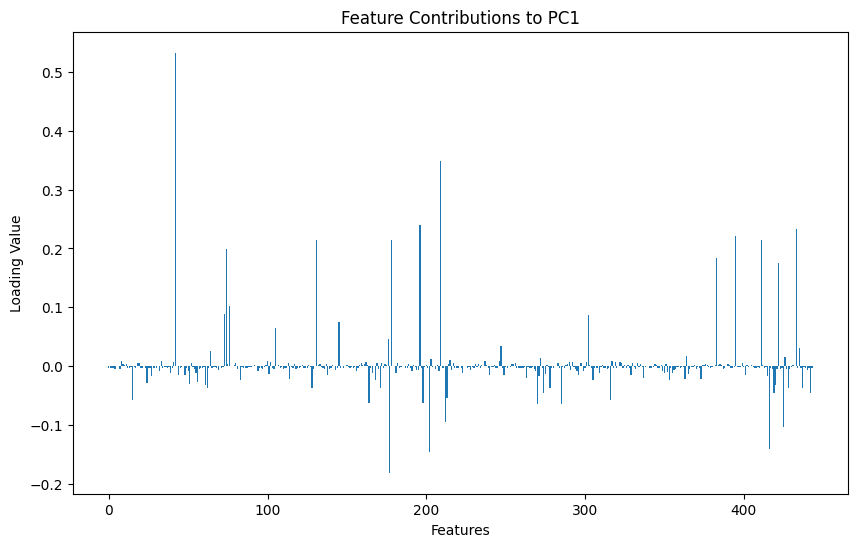

In [41]:
# Example: Visualize loadings for the first component
plt.figure(figsize=(10, 6))
plt.bar(range(len(loadings.loc['PC1'])), loadings.loc['PC1'])
plt.xlabel("Features")
plt.ylabel("Loading Value")
plt.title("Feature Contributions to PC1")
plt.show()


In [42]:
# Look at the transformed data
reduced_df = pd.DataFrame(
    X_reduced, 
    columns=[f"PC{i}" for i in range(1, X_reduced.shape[1] + 1)]
)

print(reduced_df.head())


        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.365872  0.004536 -0.328057 -0.310890 -0.183547  0.128405  0.219308   
1 -0.387094 -0.054916 -0.095483 -0.085221 -0.104328 -0.218151  0.584125   
2  0.190388  0.272906 -0.175734  0.825369 -0.449587 -0.047199 -0.496767   
3 -0.365662  0.033475 -0.137073  0.256089  0.045144 -0.134672  0.154156   
4  0.242715  0.240108 -0.499426  0.407845  0.263097 -0.130342 -0.128435   

        PC8       PC9      PC10  
0 -0.397147  0.158654  0.236169  
1 -0.386054 -0.079069 -0.197313  
2  0.305237 -0.872784 -0.612197  
3 -0.570288 -0.399928  0.296255  
4  0.071574 -0.359201  0.095152  


In [ ]:
# Step 1: Reduce data to 3D using PCA
pca = PCA(n_components=20)
TX_reduced = pca.fit_transform(TX_dense)

# Step 2: Agglomerative Hierarchical Clustering
# Using Ward's linkage method
k = 7  # Specify the number of clusters
# Use PCA-reduced data for clustering instead of original data
agg_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
labels = agg_clustering.fit_predict(TX_reduced)  # Use TX_reduced for clustering

# Step 3: Evaluate clustering with silhouette score
silhouette_avg = silhouette_score(TX_reduced, labels)
print(f"Silhouette Score: {silhouette_avg}")

# Step 4: Visualization of dendrogram
plt.figure(figsize=(10, 7))
plt.title("Dendrogram (Ward's Linkage)")
dendrogram = sch.dendrogram(sch.linkage(TX_dense, method='ward'))
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

documents = documents.iloc[:, 2]

# Trim the documents array to match the length of TX_reduced and labels
original_texts = tpf['text']  # Original text
documents = documents[:len(TX_reduced)]
original_texts = original_texts[:len(TX_reduced)]

# Select the first 3 principal components for visualization
TX_reduced = TX_reduced[:, :3]

# Now create the DataFrame with the matched lengths
data_visualization = pd.DataFrame({
    'PCA1': TX_reduced[:, 0],
    'PCA2': TX_reduced[:, 1],
    'PCA3': TX_reduced[:, 2],
    'Cluster': labels,
    'Document': documents,
    'Original': original_texts  # Uncomment if you want to include original text
})

# Check that the lengths of the columns match
print(f"Length of TX_reduced: {len(TX_reduced)}")
print(f"Length of documents: {len(documents)}")
print(f"Length of original_texts: {len(original_texts)}")
print(f"Length of labels: {len(labels)}")

# Create a 3D scatter plot using Plotly
fig = px.scatter_3d(
    data_visualization,
    x='PCA1',
    y='PCA2',
    z='PCA3',
    color='Cluster',
    hover_data={
        'Document': True,          # Cleaned text
        'Original': True,          # Original text
        'Cluster': True,           # Cluster ID
    },
    title="Agglomerative Clustering (Interactive 3D Visualization)"
)

# Customize the layout
fig.update_layout(
    scene=dict(
        xaxis_title='PCA Component 1',
        yaxis_title='PCA Component 2',
        zaxis_title='PCA Component 3',
    ),
    coloraxis_colorbar=dict(title="Cluster"),
    margin=dict(l=0, r=0, b=0, t=40)  # Adjust margins
)

# Show the plot
fig.show()